In [ ]:
import polars as pl
import pandas as pd


# 讀取 parquet
train_filled = pl.read_parquet("data/train_filled_v1_with_all.parquet")

# 讀取top50 features
save_dir = "model_output/selected_features_xgb/one_model/features_v1_with_all/model_par_2/"
df = pd.read_csv("model_output/all_features_xgb/v1_add_all/v1_model/model_importance/common_features_with_ranks.csv")
# 篩選 min_rank_overall != 9999
filtered_features = df[df["min_rank_overall"] != 9999]["feature"].tolist()

# 你要保留的欄位 (Top50 + target + group id)
cols_to_keep = filtered_features + ["selected", "ranker_id", "companyID"]

# 只保留這些欄位
train_filled = train_filled.select(cols_to_keep)

print(f"✅ DataFrame 現在只有 {len(train_filled.columns)} 欄位: {train_filled.columns}")



✅ DataFrame 現在只有 202 欄位: ['total_num_transfers_rank', 'legs0_segments0_flightNumber', 'price_per_duration_rank', 'price_percentile', 'price_from_median_zscore', 'price_per_duration', 'legs0_segments0_baggageAllowance_quantity', 'price_minus_fee_rank', 'legs0_arrivalAt_hour', 'pricingInfo_isAccessTP', 'legs0_departureAt_hour', 'both_legs_carrier_all_same', 'total_weighted_mean_cabin', 'price_per_fee_rank', 'totalPrice_rank', 'days_before_departure', 'legs0_segments0_seatsAvailable', 'price_per_fee', 'price_per_tax', 'legs1_main_carrier', 'isVip', 'leg0_view_diff_mean', 'legs1_departureAt_hour', 'baggage_total', 'duration_ratio', 'total_fees', 'all_view_diff_mean', 'legs1_arrivalAt_hour', 'log_price', 'legs1_segments0_flightNumber', 'legs1_weighted_mean_cabin', 'companyID_loo_mean_legs0_departureAt_hour', 'legs0_segments0_cabinClass', 'price_minus_fee', 'legs0_main_carrier', 'companyID_loo_mean_legs0_arrivalAt_hour', 'baggage_total_rank', 'legs0_max_duration_cabin', 'legs0_segments0_key_

In [2]:
import numpy as np

unique_rankers = train_filled.select("ranker_id").unique().to_series().to_list()

# 打亂
np.random.seed(42)
np.random.shuffle(unique_rankers)

# 切8:2
n_train = int(0.8 * len(unique_rankers))
train_rankers = set(unique_rankers[:n_train])
val_rankers = set(unique_rankers[n_train:])

df_train = train_filled.filter(pl.col("ranker_id").is_in(train_rankers))
df_val = train_filled.filter(pl.col("ranker_id").is_in(val_rankers))


# companyID

/opt/anaconda3/envs/FlightRank/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_37181/50758542.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


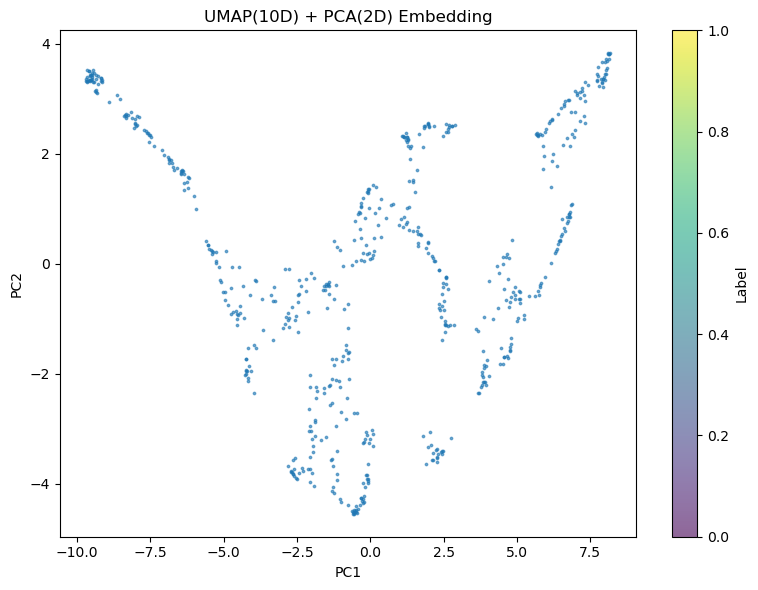

In [10]:
company_agg_train = (
    df_train.filter(pl.col("selected")==1)
    .group_by("companyID")
    .mean()
)
X_umap_train = company_agg_train.drop(["companyID", "selected", "ranker_id"]).to_numpy()
import umap

umap_model = umap.UMAP(n_components = 10, random_state=42)
X_umap_train_embedded = umap_model.fit_transform(X_umap_train)
# import joblib

# # 儲存
# joblib.dump(umap_model, "umap_model__mean_selected.joblib")
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA 再降到2維
pca = PCA(n_components=2, random_state=42)
X_pca_2d = pca.fit_transform(X_umap_train_embedded)

# 畫散點圖
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca_2d[:,0],
    X_pca_2d[:,1],
    cmap='Spectral',
    s=3,
    alpha=0.6
)
plt.title("UMAP(10D) + PCA(2D) Embedding")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Label")
plt.tight_layout()
plt.show()



# ranker_id

In [ ]:
ranker_agg_train = (
    df_train.filter(pl.col("selected")==1)
    .group_by("ranker_id")
    .mean()
)
X_umap_train = ranker_agg_train.drop(["companyID", "selected", "ranker_id"]).to_numpy()
X_umap_train.shape

(84431, 199)

In [4]:
import umap

umap_model = umap.UMAP(n_components = 10, random_state=42)
X_umap_train_embedded = umap_model.fit_transform(X_umap_train)


/opt/anaconda3/envs/FlightRank/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/FlightRank/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/FlightRank/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [ ]:

# PCA 再降到2維
pca = PCA(n_components=2, random_state=42)
X_pca_2d = pca.fit_transform(X_umap_train_embedded)

# 畫散點圖
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca_2d[:,0],
    X_pca_2d[:,1],
    cmap='Spectral',
    s=3,
    alpha=0.6
)
plt.title("UMAP(10D) + PCA(2D) Embedding")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Label")
plt.tight_layout()
plt.show()



# train + test

In [ ]:
import polars as pl
import pandas as pd
import numpy as np
import umap
import joblib

# 讀取 parquet
train_filled = pl.read_parquet("data/train_filled_v1_with_all.parquet")
test_filled = pl.read_parquet("data/test_filled_v1_with_all.parquet")

# 讀取 top features
df = pd.read_csv("model_output/all_features_xgb/v1_add_all/v1_model/model_importance/common_features_with_ranks.csv")
filtered_features = df[df["min_rank_overall"] != 9999]["feature"].tolist()

# 需要保留的欄位
cols_to_keep = filtered_features + ["selected", "ranker_id", "companyID"]

# 篩選
train_filled = train_filled.select(cols_to_keep)
test_filled = test_filled.select([c for c in cols_to_keep if c in test_filled.columns])

print(f"✅ Train欄位數: {len(train_filled.columns)}")
print(f"✅ Test欄位數: {len(test_filled.columns)}")

# 隨機抽樣
train_sample = train_filled.sample(n=5000000, seed=42)
del train_filled
import gc
gc.collect()
test_sample = test_filled.sample(n=3000000, seed=42)
del test_filled
gc.collect()
# 加來源標籤
train_sample = train_sample.with_columns(pl.lit("train").alias("source"))
test_sample = test_sample.with_columns(pl.lit("test").alias("source"))

# 確認共同欄位
common_cols = [c for c in train_sample.columns if c in test_sample.columns]
print(f"✅ 共有欄位: {common_cols}")

# 統一型別：先只保留共同欄位
train_sample = train_sample.select(common_cols)
test_sample = test_sample.select(common_cols)

# 把 numeric欄轉Float32，其餘都轉Utf8
# 統一型別：改這裡
def unify_dtypes(df):
    # df.schema: dict {col: dtype}
    return df.with_columns([
        (
            pl.col(c).cast(pl.Float32)
            if df.schema[c] in pl.NUMERIC_DTYPES
            else pl.col(c).cast(pl.Utf8)
        )
        for c in df.columns
    ])

train_sample = unify_dtypes(train_sample)
test_sample = unify_dtypes(test_sample)

# 再concat
sample_all = pl.concat([train_sample, test_sample])

print(f"✅ 合併後 shape: {sample_all.shape}")

# 去掉id欄
X_numeric = (
    sample_all
    .drop([c for c in ["companyID", "selected", "ranker_id", "source"] if c in sample_all.columns])
    .to_numpy()
)

source_labels = sample_all["source"].to_list()
print(f"✅ UMAP輸入 shape: {X_numeric.shape}")

# Fit UMAP
umap_model = umap.UMAP(n_components=10, random_state=42)
X_umap_embedded = umap_model.fit_transform(X_numeric)

# 儲存
joblib.dump(umap_model, "umap_model_rowlevel_train_test.joblib")
print("✅ UMAP模型已儲存")

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca_2d = pca.fit_transform(X_umap_embedded)

# 畫散點
import matplotlib.pyplot as plt
source_to_color = {"train": "blue", "test": "green"}
colors = [source_to_color[s] for s in source_labels]

plt.figure(figsize=(8,6))
plt.scatter(
    X_pca_2d[:,0],
    X_pca_2d[:,1],
    c=colors,
    s=5,
    alpha=0.6
)
plt.title("UMAP+PCA Embedding (Train vs Test)")
plt.xlabel("PC1")
plt.ylabel("PC2")
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=clr, markersize=8)
           for clr in source_to_color.values()]
plt.legend(handles, source_to_color.keys())
plt.tight_layout()
plt.show()


✅ Train欄位數: 202
✅ Test欄位數: 201
✅ 共有欄位: ['total_num_transfers_rank', 'legs0_segments0_flightNumber', 'price_per_duration_rank', 'price_percentile', 'price_from_median_zscore', 'price_per_duration', 'legs0_segments0_baggageAllowance_quantity', 'price_minus_fee_rank', 'legs0_arrivalAt_hour', 'pricingInfo_isAccessTP', 'legs0_departureAt_hour', 'both_legs_carrier_all_same', 'total_weighted_mean_cabin', 'price_per_fee_rank', 'totalPrice_rank', 'days_before_departure', 'legs0_segments0_seatsAvailable', 'price_per_fee', 'price_per_tax', 'legs1_main_carrier', 'isVip', 'leg0_view_diff_mean', 'legs1_departureAt_hour', 'baggage_total', 'duration_ratio', 'total_fees', 'all_view_diff_mean', 'legs1_arrivalAt_hour', 'log_price', 'legs1_segments0_flightNumber', 'legs1_weighted_mean_cabin', 'companyID_loo_mean_legs0_departureAt_hour', 'legs0_segments0_cabinClass', 'price_minus_fee', 'legs0_main_carrier', 'companyID_loo_mean_legs0_arrivalAt_hour', 'baggage_total_rank', 'legs0_max_duration_cabin', 'legs0_

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_64182/1340497582.py:50: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  if df.schema[c] in pl.NUMERIC_DTYPES


✅ 合併後 shape: (500000, 202)
✅ UMAP輸入 shape: (500000, 199)


/opt/anaconda3/envs/FlightRank/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/FlightRank/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


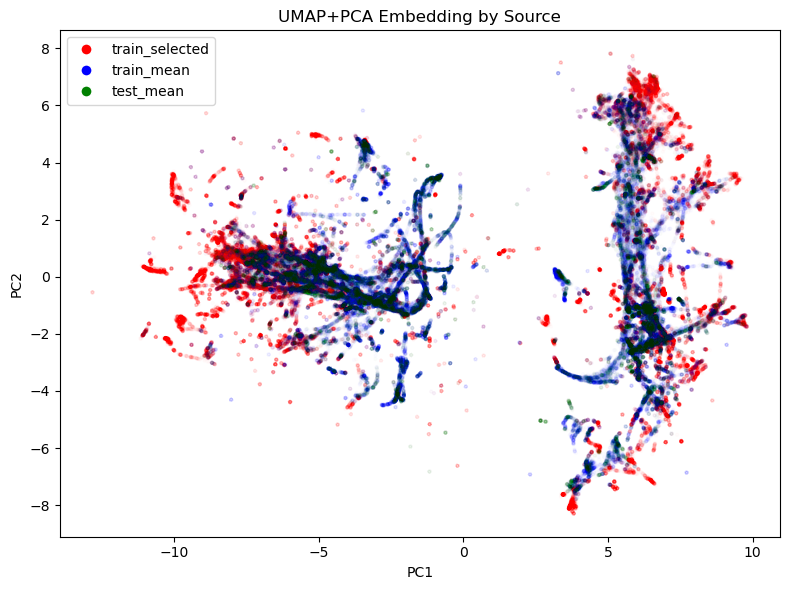

In [ ]:

# 畫散點
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca_2d[:,0],
    X_pca_2d[:,1],
    c=colors,
    s=5,
    alpha=0.01
)
plt.title("UMAP+PCA Embedding by Source")
plt.xlabel("PC1")
plt.ylabel("PC2")
# 做 legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=clr, markersize=8)
           for clr in source_to_color.values()]
plt.legend(handles, source_to_color.keys())
plt.tight_layout()
plt.show()


# apply

In [ ]:
import polars as pl
import pandas as pd
import joblib
import numpy as np

# 讀取 parquet
train_filled = pl.read_parquet("data/test_filled_v1_with_all.parquet")

# 讀取 top features
df = pd.read_csv("model_output/all_features_xgb/v1_add_all/v1_model/model_importance/common_features_with_ranks.csv")
filtered_features = df[df["min_rank_overall"] != 9999]["feature"].tolist()
cols_to_keep = filtered_features + ["Id"]

# 篩選
train_filled = train_filled.select(cols_to_keep)

print(f"✅ DataFrame 現在只有 {len(train_filled.columns)} 欄位: {train_filled.columns}")

# 分開 Id
id_series = train_filled["Id"]

# 去掉Id
X_np = train_filled.drop("Id").to_numpy()

# 釋放Polars
del train_filled, df
import gc
gc.collect()

# 讀取UMAP模型
umap_model = joblib.load("umap_model_rowlevel_train_test.joblib")
print("✅ 已讀取UMAP模型")

# 批次處理
batch_size = 1000000
n_samples = X_np.shape[0]
batches = []

for start in range(0, n_samples, batch_size):
    end = min(start + batch_size, n_samples)
    print(f"🔹 Transforming batch: {start} - {end}")
    
    batch_emb = umap_model.transform(X_np[start:end])
    batches.append(batch_emb)
    gc.collect()

# 拼接
X_umap = np.vstack(batches)
print(f"✅ 完成所有批次，shape={X_umap.shape}")

# 回存DataFrame
umap_cols = [f"umap_{i}" for i in range(X_umap.shape[1])]
df_umap = pl.DataFrame(X_umap, schema=umap_cols)

# 拼回 Id
df_result = pl.concat([id_series.to_frame(), df_umap], how="horizontal")

print("✅ 完成UMAP降維 + Id合併")
print(df_result.head())

# 範例: 儲存
df_result.write_parquet("data/extra_features/test/13_umap_features.parquet")


✅ DataFrame 現在只有 200 欄位: ['total_num_transfers_rank', 'legs0_segments0_flightNumber', 'price_per_duration_rank', 'price_percentile', 'price_from_median_zscore', 'price_per_duration', 'legs0_segments0_baggageAllowance_quantity', 'price_minus_fee_rank', 'legs0_arrivalAt_hour', 'pricingInfo_isAccessTP', 'legs0_departureAt_hour', 'both_legs_carrier_all_same', 'total_weighted_mean_cabin', 'price_per_fee_rank', 'totalPrice_rank', 'days_before_departure', 'legs0_segments0_seatsAvailable', 'price_per_fee', 'price_per_tax', 'legs1_main_carrier', 'isVip', 'leg0_view_diff_mean', 'legs1_departureAt_hour', 'baggage_total', 'duration_ratio', 'total_fees', 'all_view_diff_mean', 'legs1_arrivalAt_hour', 'log_price', 'legs1_segments0_flightNumber', 'legs1_weighted_mean_cabin', 'companyID_loo_mean_legs0_departureAt_hour', 'legs0_segments0_cabinClass', 'price_minus_fee', 'legs0_main_carrier', 'companyID_loo_mean_legs0_arrivalAt_hour', 'baggage_total_rank', 'legs0_max_duration_cabin', 'legs0_segments0_key_

KeyboardInterrupt: 

In [ ]:
import polars as pl
import pandas as pd
import joblib
import numpy as np

# 讀取 parquet
train_filled = pl.read_parquet("data/train_filled_v1_with_all.parquet")

# 讀取 top features
df = pd.read_csv("model_output/all_features_xgb/v1_add_all/v1_model/model_importance/common_features_with_ranks.csv")
filtered_features = df[df["min_rank_overall"] != 9999]["feature"].tolist()
cols_to_keep = filtered_features + ["Id"]

# 篩選
train_filled = train_filled.select(cols_to_keep)

print(f"✅ DataFrame 現在只有 {len(train_filled.columns)} 欄位: {train_filled.columns}")

# 分開 Id
id_series = train_filled["Id"]

# 去掉Id
X_np = train_filled.drop("Id").to_numpy()

# 釋放Polars
del train_filled, df
import gc
gc.collect()

# 讀取UMAP模型
umap_model = joblib.load("umap_model_rowlevel_train_test.joblib")
print("✅ 已讀取UMAP模型")

# 批次處理
batch_size = 1000000
n_samples = X_np.shape[0]
batches = []

for start in range(0, n_samples, batch_size):
    end = min(start + batch_size, n_samples)
    print(f"🔹 Transforming batch: {start} - {end}")
    
    batch_emb = umap_model.transform(X_np[start:end])
    batches.append(batch_emb)
    gc.collect()

# 拼接
X_umap = np.vstack(batches)
print(f"✅ 完成所有批次，shape={X_umap.shape}")

# 回存DataFrame
umap_cols = [f"umap_{i}" for i in range(X_umap.shape[1])]
df_umap = pl.DataFrame(X_umap, schema=umap_cols)

# 拼回 Id
df_result = pl.concat([id_series.to_frame(), df_umap], how="horizontal")

print("✅ 完成UMAP降維 + Id合併")
print(df_result.head())

# 範例: 儲存
df_result.write_parquet("data/extra_features/train/13_umap_features.parquet")


✅ 已讀取train/test資料
✅ 合併完成, shape=(25043148, 10)


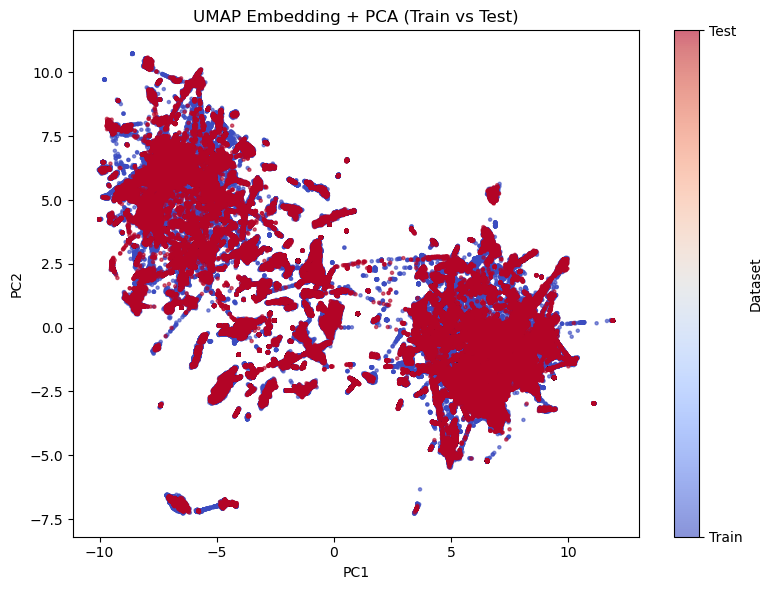

: 

In [ ]:
import polars as pl
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 讀取 parquet
train_df = pl.read_parquet("data/extra_features/train/13_umap_features.parquet")
test_df = pl.read_parquet("data/extra_features/test/13_umap_features.parquet")

print("✅ 已讀取train/test資料")

# 把Id分開
train_ids = train_df["Id"].to_numpy()
test_ids = test_df["Id"].to_numpy()

# 去掉Id
X_train = train_df.drop("Id").to_numpy()
X_test = test_df.drop("Id").to_numpy()

# 合併
X_all = np.vstack([X_train, X_test])
y_all = np.concatenate([
    np.zeros(len(X_train)),  # Train標0
    np.ones(len(X_test))     # Test標1
])

print(f"✅ 合併完成, shape={X_all.shape}")

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca_2d = pca.fit_transform(X_all)

# 畫圖
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca_2d[:,0],
    X_pca_2d[:,1],
    c=y_all,
    cmap="coolwarm",
    s=5,
    alpha=0.6
)
plt.title("UMAP Embedding + PCA (Train vs Test)")
plt.xlabel("PC1")
plt.ylabel("PC2")
cbar = plt.colorbar(scatter, ticks=[0,1])
cbar.set_label("Dataset")
cbar.set_ticklabels(["Train", "Test"])
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
import polars as pl

# 排除列
exclude_cols = ['Id', 'ranker_id', 'selected']
feature_cols = [col for col in train_filled.columns if col not in exclude_cols]
print(f"Using {len(feature_cols)} features")

# 我們先把全部需要的欄位一次select
df_all = train_filled.select(['ranker_id'] + ['selected'] + feature_cols)

# ranker_id去重
unique_rankers = df_all.select("ranker_id").unique().to_series().to_list()

# 打亂
np.random.seed(42)
np.random.shuffle(unique_rankers)

# 切8:2
n_train = int(0.8 * len(unique_rankers))
train_rankers = set(unique_rankers[:n_train])

# 標記is_train
df_all = df_all.with_columns(
    pl.col("ranker_id").is_in(train_rankers).alias("is_train")
)

# 分割
df_train = df_all.filter(pl.col("is_train"))
df_val = df_all.filter(~pl.col("is_train"))

# 切X/y
X_train_np = df_train.select(feature_cols).to_numpy()
y_train_np = df_train["selected"].to_numpy()
X_val_np = df_val.select(feature_cols).to_numpy()
y_val_np = df_val["selected"].to_numpy()

print("✅ 完成資料切分")
print("Train size:", X_train_np.shape, " Val size:", X_val_np.shape)


Using 20 features
✅ 完成資料切分
Train size: (14445656, 20)  Val size: (3699716, 20)


In [ ]:

train_new, transform_dict = build_company_loo_features(train_filled,
                                                       output_dir= "data/extra_features/train")


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_96862/3811100871.py:101: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("selected_count")
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_96862/3811100871.py:111: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("selected_count")
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_96862/3811100871.py:157: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count")
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_96862/3811100871.py:162: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("total_occurrences"))


✅ 已儲存 transform_dict: data/extra_features/train/12_companyID_features.parquet
✅ 已儲存 transform_dict: data/extra_features/train/transform_dict_companyID.pkl


In [3]:
from lightgbm import early_stopping, log_evaluation, LGBMClassifier

clf = LGBMClassifier(
    objective="binary",
    class_weight="balanced",
    learning_rate=0.05,
    num_leaves=128,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=10.0,
    random_state=42,
    n_estimators=500,
    n_jobs=-1
)

clf.fit(
    X_train_np,
    y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_metric=["binary_logloss", "auc"],
    callbacks=[
        early_stopping(stopping_rounds=50, verbose=True),
        log_evaluation(20)
    ],
    feature_name=feature_cols  # ✅ 在這裡明確告訴LightGBM特徵名稱
)



# 預測機率
y_val_pred_proba = clf.predict_proba(X_val_np)[:,1]
print("前10筆機率:", y_val_pred_proba[:10])

from sklearn.metrics import classification_report, confusion_matrix

y_val_pred_label = clf.predict(X_val_np)

print(classification_report(y_val_np, y_val_pred_label))
print(confusion_matrix(y_val_np, y_val_pred_label))




[LightGBM] [Info] Number of positive: 84431, number of negative: 14361225
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.613907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2743
[LightGBM] [Info] Number of data points in the train set: 14445656, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
[20]	valid_0's binary_logloss: 0.432191	valid_0's auc: 0.928876
[40]	valid_0's binary_logloss: 0.363672	valid_0's auc: 0.933497
[60]	valid_0's binary_logloss: 0.338657	valid_0's auc: 0.936904
[80]	valid_0's binary_logloss: 0.326686	valid_0's auc: 0.939173
[100]	valid_0's binary_logloss: 0.317938	valid_0's auc: 0.941363
[120]	valid_0's binary_logloss: 0.311034	valid_0's auc: 

/opt/anaconda3/envs/FlightRank/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


前10筆機率: [0.99140091 0.64615252 0.43772315 0.01080807 0.00822298 0.63890176
 0.44234942 0.00563728 0.00481942 0.60222049]


/opt/anaconda3/envs/FlightRank/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.88      0.93   3678608
           1       0.04      0.88      0.08     21108

    accuracy                           0.88   3699716
   macro avg       0.52      0.88      0.51   3699716
weighted avg       0.99      0.88      0.93   3699716

[[3229070  449538]
 [   2508   18600]]


In [4]:

import os 
# 📌 儲存模型
model_path = os.path.join(save_dir, f"top{n_top}")
os.makedirs(model_path, exist_ok=True)
model_file = os.path.join(model_path, "lgb_classifer_model.txt")

clf.booster_.save_model(model_file)
print(f"✅ 已儲存模型到 'lgb_classifer_model.txt' in {model_file}")


✅ 已儲存模型到 'lgb_classifer_model.txt' in model_output/selected_features_xgb/one_model/top20/lgb_classifer_model.txt


In [5]:
import polars as pl

def compute_topk_hit_rate(df_topk: pl.DataFrame, df_ground_truth: pl.DataFrame, K: int) -> float:
    """
    計算 Top-K 命中率（HitRate@K）
    """
    # 僅保留 Ground Truth 的正例
    df_pos = df_ground_truth.filter(pl.col("selected") == 1).select(["ranker_id"])
    
    # 將每個ranker_id的Top-K取出
    df_topk_k = df_topk.filter(pl.col("rank_in_group") <= K).select(["ranker_id"]).unique()

    # inner join: 有命中的正例
    df_hit = df_pos.join(df_topk_k, on="ranker_id", how="inner")

    num_hit = df_hit.height
    num_total = df_pos.height

    hit_rate = num_hit / num_total if num_total > 0 else 0.0
    
    num_positive = df_ground_truth.filter(pl.col("selected") == 0).height
    print(f"✅ df_val 中 selected=0 的數量: {num_positive}")

    print(f"✅ HitRate@{K}: {hit_rate:.4f} ({num_hit}/{num_total})")
    return hit_rate
# 預測機率
y_val_pred_proba = clf.predict_proba(X_val_np)[:,1]

# 建df_pred
df_pred = df_val.select(["ranker_id"]).with_columns(
    pl.Series("score", y_val_pred_proba)
)

# 排序 rank_in_group
df_pred = df_pred.with_columns(
    pl.col("score").rank("ordinal", descending=True).over("ranker_id").alias("rank_in_group")
)

# 計算Top-K命中率
hit_rate = compute_topk_hit_rate(
    df_topk=df_pred,
    df_ground_truth=df_val,
    K=50
)



/opt/anaconda3/envs/FlightRank/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ df_val 中 selected=0 的數量: 3678608
✅ HitRate@50: 1.0000 (21108/21108)


In [ ]:
num_positive = df_val.filter(pl.col("selected") == 0).height
print(f"✅ df_val 中 selected=0 的數量: {num_positive}")


✅ df_val 中 selected=1 的數量: 3598742


In [12]:
df_pred

ranker_id,score,rank_in_group
str,f64,u32
"""98ce0dabf6964640b63079fbafd42c…",0.994294,1
"""98ce0dabf6964640b63079fbafd42c…",0.679394,2
"""98ce0dabf6964640b63079fbafd42c…",0.526543,6
"""98ce0dabf6964640b63079fbafd42c…",0.004755,16
"""98ce0dabf6964640b63079fbafd42c…",0.006912,14
…,…,…
"""be21a1ace59f41729922828a72c9e3…",0.016521,45
"""be21a1ace59f41729922828a72c9e3…",0.000974,58
"""be21a1ace59f41729922828a72c9e3…",0.015265,47


In [ ]:
# 計算Top-K命中率
hit_rate = compute_topk_hit_rate(
    df_topk=df_pred,
    df_ground_truth=df_val,
    K=
)

✅ df_val 中 selected=0 的數量: 3678608
✅ HitRate@1: 1.0000 (21108/21108)


# Prediction

In [ ]:
import os
import numpy as np
import polars as pl
from lightgbm import Booster

# 參數
model_path = "model_output/selected_features_xgb/one_model/top20/lgb_classifer_model.txt"
parquet_path = "data/test_filled.parquet"

# 讀取模型 (用Booster)
booster = Booster(model_file=model_path)

# 確認 feature_names
model_features = booster.feature_name()
if model_features is None:
    raise ValueError("❌ 模型沒有 feature_names，請確認訓練時有指定 feature_names")
print(f"✅ 模型共 {len(model_features)} 個features")

# 讀取 test_filled
df = pl.read_parquet(parquet_path)
print(f"✅ 讀取 test_filled，共 {df.height} rows")

# 檢查缺失
missing_in_data = [f for f in model_features if f not in df.columns]
if missing_in_data:
    raise ValueError(f"❌ 下列特徵在 test_filled 不存在: {missing_in_data}")

# 篩選
df_for_predict = df.select(model_features)
X_np = df_for_predict.to_numpy()

# 預測 (Booster.predict 直接回傳概率)
preds = booster.predict(X_np)
print(f"✅ 預測完成，共 {len(preds)} 筆")

# 回存結果
df_result = (
    df
    .with_columns([
        pl.Series("selected", preds)
    ])
)


✅ 模型共 20 個features


✅ 讀取 test_filled，共 6897776 rows
✅ 預測完成，共 6897776 筆


In [11]:
import os
import polars as pl

def export_submission_parquets(
    test_filled_with_preds: pl.DataFrame,
    output_dir: str,
    raw_filename: str = "raw_submission.parquet",
    ranked_filename: str = "rank_submission.parquet"
):
    """
    根據 test_filled_with_preds 輸出兩個 parquet:
    1. 原始分數 (selected)
    2. rank 排序 (selected)
    """
    # 檢查目錄
    os.makedirs(output_dir, exist_ok=True)

    # Subset + __index_level_0__
    subset_df = (
        test_filled_with_preds
        .select(["Id", "ranker_id", "selected"])
        .with_columns(
            pl.col("Id").alias("__index_level_0__")
        )
        .with_columns([
            pl.col("Id").cast(pl.Int64),
            pl.col("ranker_id").cast(pl.Utf8),
            pl.col("selected").cast(pl.Float64),
            pl.col("__index_level_0__").cast(pl.Int64)
        ])
    )

    # 儲存原始 parquet
    raw_path = os.path.join(output_dir, raw_filename)
    subset_df.write_parquet(raw_path)
    print(f"✅ 已儲存原始 submission: {raw_path}")
    print(subset_df)

    # Rank 排名
    ranked_df = subset_df.with_columns(
        pl.col("selected")
          .rank(method="ordinal", descending=True)
          .over("ranker_id")
          .alias("selected")
    )

    # 儲存排名 parquet
    ranked_path = os.path.join(output_dir, ranked_filename)
    ranked_df.write_parquet(ranked_path)
    print(f"✅ 已儲存rank submission: {ranked_path}")
    print(ranked_df)
    
n_top = 20
export_submission_parquets(
    test_filled_with_preds=df_result,   # 你的帶有 selected 分數的 DataFrame
    output_dir=f"model_output/selected_features_xgb/one_model/top{n_top}",
    ranked_filename = "lgb_classifer_rank_submission.parquet",
    raw_filename ="lgb_classifer_raw_submission.parquet",
)


✅ 已儲存原始 submission: model_output/selected_features_xgb/one_model/top20/lgb_classifer_raw_submission.parquet
shape: (6_897_776, 4)
┌──────────┬─────────────────────────────────┬──────────┬───────────────────┐
│ Id       ┆ ranker_id                       ┆ selected ┆ __index_level_0__ │
│ ---      ┆ ---                             ┆ ---      ┆ ---               │
│ i64      ┆ str                             ┆ f64      ┆ i64               │
╞══════════╪═════════════════════════════════╪══════════╪═══════════════════╡
│ 18144679 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 0.327041 ┆ 18144679          │
│ 18144680 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 0.664309 ┆ 18144680          │
│ 18144681 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 0.120555 ┆ 18144681          │
│ 18144682 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 0.449987 ┆ 18144682          │
│ 18144683 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 0.309593 ┆ 18144683          │
│ …        ┆ …                               ┆ …        ┆ …                 │
│ 25043143 ┆

In [ ]:
from scripts.result_esemble import compute_ranked_average_selected_from_submissions

submission_paths = [
    "model_output/selected_features_xgb/one_model/top60/raw_submission.parquet",
    "model_output/all_features_xgb/2_raw_submission.parquet",
    "model_output/all_features_xgb/raw_submission.parquet",
    "model_output/selected_features_xgb/one_model/top20/raw_submission.parquet"
]

avg_df = compute_ranked_average_selected_from_submissions(submission_paths)

# 顯示前5筆
print(avg_df.head())

# 如需輸出
avg_df.write_parquet("submission_selected_mean.parquet")
print("✅ 已輸出平均submission")


✅ 讀取: model_output/selected_features_xgb/one_model/top60/raw_submission.parquet
✅ 讀取: model_output/all_features_xgb/2_raw_submission.parquet
✅ 讀取: model_output/all_features_xgb/raw_submission.parquet
✅ 讀取: model_output/selected_features_xgb/one_model/top20/raw_submission.parquet
✅ 完成 6897776 筆平均+排名計算
shape: (5, 4)
┌──────────┬─────────────────────────────────┬──────────┬───────────────────┐
│ Id       ┆ ranker_id                       ┆ selected ┆ __index_level_0__ │
│ ---      ┆ ---                             ┆ ---      ┆ ---               │
│ i64      ┆ str                             ┆ u32      ┆ i64               │
╞══════════╪═════════════════════════════════╪══════════╪═══════════════════╡
│ 18144679 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 98       ┆ 18144679          │
│ 18144680 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 32       ┆ 18144680          │
│ 18144681 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 223      ┆ 18144681          │
│ 18144682 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 122      ┆ 18